# 目标检测

In [61]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.patches as patches
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 基础知识

目标检测（Object Detection）是一项计算机视觉任务，其目标是在图像或视频中识别并定位所有目标对象，同时对每个对象进行分类。以下是目标检测算法相关的基础知识和主要方法分类：

1、目标检测算法的主要任务  
- 分类：判断图片中是否存在目标对象。
- 定位：给出目标对象的边界框（Bounding Box）。
- 多目标检测：在一幅图片中检测多个目标并分类。

2、目标检测的主要方法  
目标检测算法可以分为两阶段方法和单阶段方法。

- 两阶段方法（Two-Stage Detectors）  
    这类方法先生成候选区域，然后对每个区域分类并回归边界框。代表性算法包括：  
    
    - R-CNN 系列  
    - R-CNN (Region-based CNN)：采用选择性搜索生成候选区域，逐一分类，效率较低。  
    - Fast R-CNN：引入ROI池化，提升了计算效率。  
    - Faster R-CNN：通过区域建议网络（RPN）生成候选框，大幅提高了速度。  
    - Mask R-CNN：在Faster R-CNN基础上增加分割分支，能完成实例分割任务。
- 单阶段方法（One-Stage Detectors）  
    这类方法直接回归边界框和分类，速度更快。代表性算法包括：  
    
    - YOLO 系列（You Only Look Once）
    - YOLOv1 ~ YOLOv8：每代模型提升精度、速度和推理能力。
    - SSD（Single Shot MultiBox Detector）：支持多尺度特征检测。
    - RetinaNet：引入Focal Loss，解决单阶段检测中正负样本比例失衡的问题。

3、目标检测的关键技术
- 特征提取
    - 卷积神经网络（CNN）：提取图像中的高级特征。
    - 骨干网络（Backbone）：
    - 经典网络：ResNet、VGG、MobileNet。
    - 专用网络：Darknet（用于YOLO）。
- 区域生成
    - 选择性搜索（Selective Search）：R-CNN使用。
    - 区域建议网络（RPN）：Faster R-CNN使用。
- 损失函数
    - 分类损失：交叉熵、Focal Loss。
    - 回归损失：Smooth L1 Loss、IoU Loss、GIoU、DIoU、CIoU。
- 多尺度特征融合
    - 特征金字塔网络（FPN）：利用金字塔结构融合不同层次的特征。
    - PANet：增强低层特征对检测的贡献。
- 数据增强
    - 旋转、缩放、翻转、颜色变换。
    - CutMix、Mosaic（YOLO系列常用）。
- 后处理
    - 非极大值抑制（NMS）：过滤冗余框。
    - Soft-NMS：对传统NMS改进，减少框误删。

## 数据准备

### 公开数据集

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 1.03G/1.03G [10:15<00:00, 1.79MB/s]

Extracting model files...


Path to dataset files: C:\Users\caoyuyu\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


In [55]:
# 解析一个标注文件
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_info = {
        "filename": root.find("filename").text,
        "width": int(root.find("size/width").text),
        "height": int(root.find("size/height").text),
        "objects": []
    }

    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        bbox = {
            "name": name,
            "xmin": int(bndbox.find("xmin").text),
            "ymin": int(bndbox.find("ymin").text),
            "xmax": int(bndbox.find("xmax").text),
            "ymax": int(bndbox.find("ymax").text),
        }
        image_info["objects"].append(bbox)

    return image_info

# 示例：解析一个标注文件
annotation_file = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/Cats_Test0.xml"
parsed_data = parse_voc_annotation(annotation_file)
print(parsed_data)

{'filename': 'Cats_Test0.png', 'width': 233, 'height': 350, 'objects': [{'name': 'cat', 'xmin': 83, 'ymin': 29, 'xmax': 197, 'ymax': 142}]}


In [56]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None, label_map=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.label_map = label_map or {}
        self.annotation_files = [
            f for f in os.listdir(annotations_dir) if f.endswith(".xml")
        ]

    def __len__(self):
        return len(self.annotation_files)

    def __getitem__(self, idx):
        annotation_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        annotation = parse_voc_annotation(annotation_path)

        img_path = os.path.join(self.images_dir, annotation["filename"])
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for obj in annotation["objects"]:
            boxes.append([obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]])
            labels.append(self.label_map[obj["name"]])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

In [57]:
# 定义数据目录路径
images_dir = "../../../../../data/02.cv/dog-and-cat-detection/images/"
annotations_dir = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/"
label_map = {"cat": 0, "dog": 1} 

# 初始化数据集
dataset = VOCDataset(images_dir, annotations_dir, label_map = label_map)

In [58]:
# 检查数据
print(f"数据集大小: {len(dataset)}")
image, target = dataset[1]  # 取出第一个样本
print(f"图片尺寸: {image.size}")
print(f"目标: {target}")

数据集大小: 3686
图片尺寸: (500, 500)
目标: {'boxes': tensor([[128.,  22., 240., 222.]]), 'labels': tensor([1])}


In [59]:
def visualize_image(image, target, label_map_reverse=None):
    """
    可视化带标签的图像。
    
    Args:
        image (PIL.Image.Image or torch.Tensor): 输入图像，可以是PIL格式或张量格式。
        target (dict): 目标字典，包含 'boxes' (坐标) 和 'labels' (标签)。
        label_map_reverse (dict, optional): 标签编号到类别名的映射。默认为None，直接显示编号。
    """
    if isinstance(image, torch.Tensor):
        # 如果是张量格式，将其转换为PIL格式
        image = transforms.ToPILImage()(image)
    
    boxes = target["boxes"]
    labels = target["labels"]

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # 获取类别名
        label_text = str(label.item())  # 如果没有 label_map_reverse，就直接显示编号
        if label_map_reverse:
            label_text = label_map_reverse.get(label.item(), str(label.item()))

        # 显示标签
        ax.text(
            x1, y1 - 5, label_text,
            color='red', fontsize=12, backgroundcolor='white'
        )

    plt.axis('off')
    plt.show()

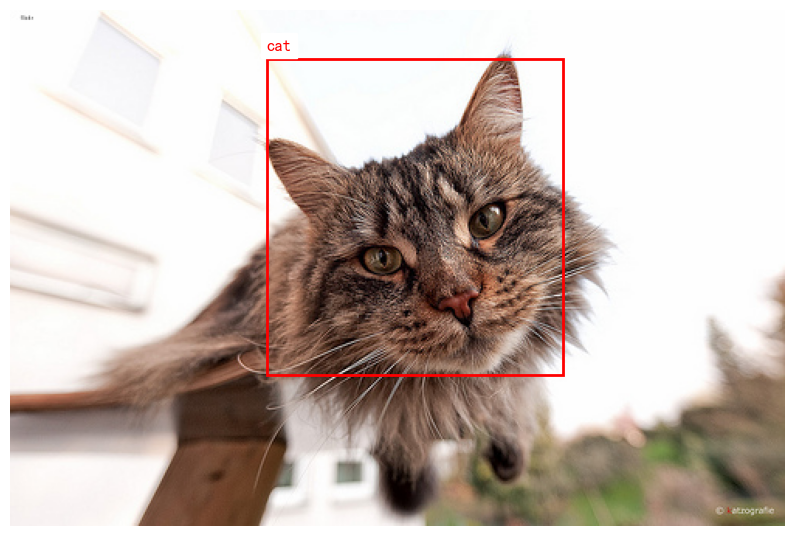

In [60]:
# 假设有一个已经加载好的数据集
label_map_reverse = {0: "cat", 1: "dog"}  # 类别编号到类别名的映射
image, target = dataset[50]  # 从数据集中获取第一个样本
visualize_image(image, target, label_map_reverse)

In [63]:
# import os
# import xml.etree.ElementTree as ET

# def convert_voc_to_txt(xml_folder, output_folder, label_map):
#     """
#     将 VOC 格式 XML 文件中的边界框坐标提取并保存为 .txt 文件。

#     Args:
#         xml_folder (str): 输入 XML 文件夹路径。
#         output_folder (str): 输出 .txt 文件夹路径。
#     """
#     # 确保输出文件夹存在
#     os.makedirs(output_folder, exist_ok=True)

#     # 遍历 XML 文件夹
#     for xml_file in os.listdir(xml_folder):
#         if not xml_file.endswith(".xml"):
#             continue
        
#         # 解析 XML 文件
#         xml_path = os.path.join(xml_folder, xml_file)
#         tree = ET.parse(xml_path)
#         root = tree.getroot()
        
#         # 提取文件名（不含扩展名）
#         file_name = os.path.splitext(xml_file)[0]
        
#         # 打开目标 .txt 文件
#         txt_path = os.path.join(output_folder, f"{file_name}.txt")
#         with open(txt_path, "w") as f:
#             # 遍历目标对象
#             for obj in root.findall("object"):
#                 bndbox = obj.find("bndbox")
#                 name = obj.find("name").text
#                 if name not in label_map:
#                     continue  # 跳过未定义的类别
#                 # 获取标签编号
#                 label = label_map[name]
#                 xmin = int(bndbox.find("xmin").text)
#                 ymin = int(bndbox.find("ymin").text)
#                 xmax = int(bndbox.find("xmax").text)
#                 ymax = int(bndbox.find("ymax").text)
                
#                 # 保存为格式化字符串
#                 f.write(f"{label} {xmin} {ymin} {xmax} {ymax}\n")
        
#         print(f"Processed: {xml_file} -> {txt_path}")

# # 示例用法
# xml_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/"  # 替换为你的 XML 文件夹路径
# output_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_txt/"  # 替换为输出文件夹路径
# label_map = {"cat": 0, "dog": 1} 

# convert_voc_to_txt(xml_folder, output_folder, label_map)

### 自定义数据集

Ultralytics 是一个专注于计算机视觉的开源工具开发公司，以其高性能的目标检测框架 YOLOv5 和 YOLOv8 而闻名。它提供了高效的深度学习模型、API 和工具，适合快速开发、训练和部署计算机视觉任务。

Ultralytics推荐的数据集结构是这样的：

这里面是一个数据集文件夹，包含images、labels两个文件夹和一个data.yaml配置文件：

- images文件夹放图像，labels文件夹放标注文件，图像和标注文件的名称要一一对应
- images和labels文件夹下分别放train、val、test三个子文件夹，作为训练集、验证集和测试集
- data.yaml的格式如下：

标注文件的格式如下：

每一行的第一个数字代表标签，后续的四个数字是标注框的\<x1> \<y1> \<x2> \<y2>相对于图像shape的归一化值（或者说比例）。  

标签文件中出现多行则代表着图像中有多个检测到的目标。

In [79]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# def organize_dataset(images_folder, labels_folder, output_folder, train_ratio=0.7, val_ratio=0.2):
#     """
#     将图片和标签文件分为 train、val 和 test 集合，并按格式存储。

#     Args:
#         images_folder (str): 图片文件夹路径。
#         labels_folder (str): 标签文件夹路径。
#         output_folder (str): 输出数据集根目录。
#         train_ratio (float): 训练集比例。
#         val_ratio (float): 验证集比例。
#     """
#     # 创建输出目录
#     image_output = os.path.join(output_folder, "images")
#     label_output = os.path.join(output_folder, "labels")
#     for split in ["train", "val", "test"]:
#         os.makedirs(os.path.join(image_output, split), exist_ok=True)
#         os.makedirs(os.path.join(label_output, split), exist_ok=True)

#     # 获取所有图片和标签文件
#     images = sorted([f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))])
#     labels = sorted([f for f in os.listdir(labels_folder) if f.endswith(".txt")])

#     # 确保图片和标签文件匹配
#     images = [img for img in images if os.path.splitext(img)[0] + ".txt" in labels]
#     labels = [lbl for lbl in labels if os.path.splitext(lbl)[0] + ".png" in images]

#     # 分割数据集
#     train_images, temp_images, train_labels, temp_labels = train_test_split(
#         images, labels, test_size=(1 - train_ratio), random_state=42
#     )
#     val_images, test_images, val_labels, test_labels = train_test_split(
#         temp_images, temp_labels, test_size=(1 - val_ratio / (1 - train_ratio)), random_state=42
#     )

#     # 定义一个函数拷贝文件
#     def copy_files(files, src_folder, dst_folder):
#         for file in files:
#             shutil.copy(os.path.join(src_folder, file), os.path.join(dst_folder, file))

#     # 拷贝图片和标签到相应目录
#     copy_files(train_images, images_folder, os.path.join(image_output, "train"))
#     copy_files(train_labels, labels_folder, os.path.join(label_output, "train"))

#     copy_files(val_images, images_folder, os.path.join(image_output, "val"))
#     copy_files(val_labels, labels_folder, os.path.join(label_output, "val"))

#     copy_files(test_images, images_folder, os.path.join(image_output, "test"))
#     copy_files(test_labels, labels_folder, os.path.join(label_output, "test"))

#     print(f"Dataset organized successfully in {output_folder}!")

#     # 生成 data.yaml 文件
#     yaml_content = f"""
# path: {output_folder}
# train: {os.path.join("images/", 'train')}
# val: {os.path.join("images/", 'val')}
# test: {os.path.join("images/", 'test')}

# nc: 2  
# names: ['cat', 'dog']  
#     """
#     with open(os.path.join(output_folder, "data.yaml"), "w") as f:
#         f.write(yaml_content.strip())
#     print(f"data.yaml file created at {os.path.join(output_folder, 'data.yaml')}")


# # 示例用法
# images_folder = "../../../../../data/02.cv/dog-and-cat-detection/images" # 替换为你的图片文件夹路径
# labels_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_txt"       # 替换为你的标签文件夹路径
# output_folder = "../../../../../data/02.cv/dog_cat_detection"     # 替换为输出文件夹路径

# organize_dataset(images_folder, labels_folder, output_folder)